In [131]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [132]:
#standard imports
import time
import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats


#let's import the SVM classifier
from sklearn.svm import LinearSVC

#our own internal utility unctions
import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)
import utils; reload(utils)
from utils import featurewise_norm, spearman_brown


In [133]:
#ok let's load the neural data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}

Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]

#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

### Simple linear regression (one predictor)

In [152]:
#Let's look at simple (one variable) linear regression from neural data to 
#the translation_z variable
#(we'll exclude the V0 component of the data since the variable of interest is not 
#actually varying on that subset)
ss = meta_array['variation_level'] != 'V0'
ty_single_ss = np.array([stats.linregress(Neural_Data[ss, i], meta_array['translation_y'][ss]) 
                   for i in range(Neural_Data.shape[1])])

In [154]:
np.abs(ty_single_ss[:, 2]).max()

0.36220333899786605

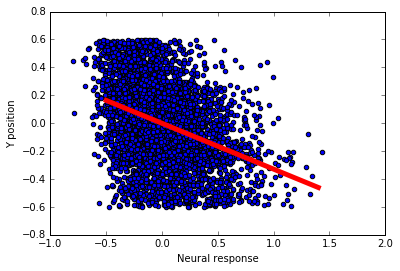

In [153]:
best_neuron = np.abs(ty_single_ss[:, 2]).argsort()[-1]
plt.scatter(Neural_Data[ss, best_neuron], meta_array['translation_y'][ss])
plt.xlabel('Neural response')
plt.ylabel('Y position')

slope = ty_single_ss[best_neuron][0]
intercept = ty_single_ss[best_neuron][1]
xr = np.arange(-.5, 1.5, .1)
plt.plot(xr, slope*xr + intercept, color='r', linewidth=5)

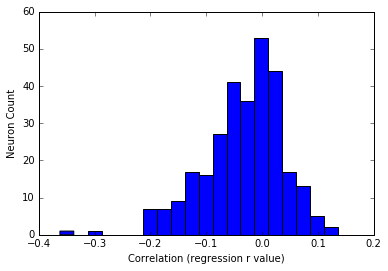

In [12]:
plt.hist(ty_single_ss[:, 2], bins=20);
plt.xlabel('Correlation (regression r value)')
plt.ylabel('Neuron Count')

#### Import detail about metrics of regression success

In [137]:
#ok let's import the LinearRegression class (this is ordinary least squares regression)
from sklearn.linear_model import LinearRegression

In [33]:
def rsquared(predicted, actual):
    """The "rsquared" metric
    """
    a_mean = actual.mean()
    num = np.linalg.norm(actual - predicted)**2
    denom = np.linalg.norm(actual - a_mean)**2
    return 1 - num / denom


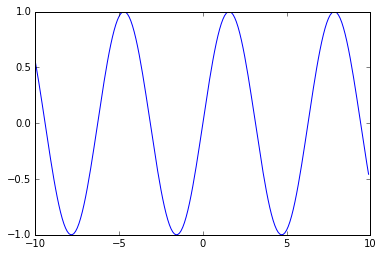

In [138]:
data = np.arange(-10, 10, .1)
plt.plot(data, np.sin(data))

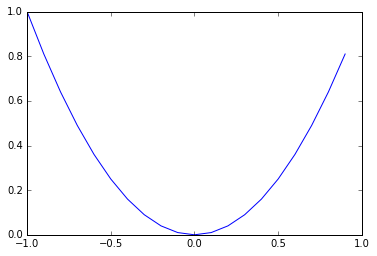

In [143]:
plt.plot(regressors1[:, 1], regressors1[:, 2])

In [145]:
model.coef_

array([  0.00000000e+00,   9.98045188e-01,  -3.64243523e-04,
        -1.57572230e-01])

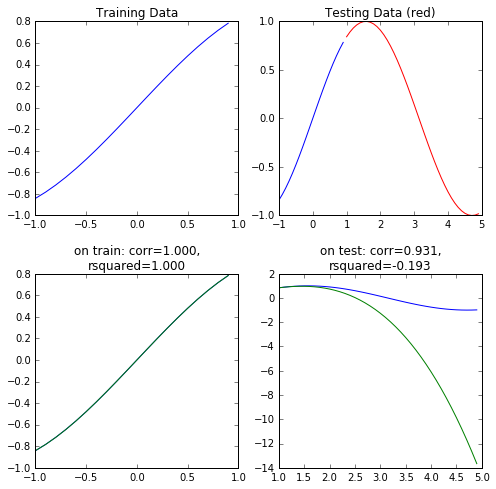

In [34]:
#Let's regress the sine function
func = np.sin

#we'll train on data range 1
data1 = np.arange(-1, 1, .1)
#and test on data range 2
data2 = np.arange(1, 5, .1)
y1 = func(data1)
y2 = func(data2)

#we'll allow predictors up to the 4th power e.g. 
#4th-order polynomials
polyorder = 4
regressors1 = np.array([data1**i for i in range(polyorder)]).T
regressors2 = np.array([data2**i for i in range(polyorder)]).T
#construct regressors all in one matrix and then subselect the data
#for the two ranges

#now let's fit the model 
model = LinearRegression()
model.fit(regressors1, y1)

#coefficients of the model recover the taylor series of func

#and get its predictions both on datarange 1 and datarange 2
predictions1 = model.predict(regressors1) #training data range
predictions2 = model.predict(regressors2) #testing data range

#and let's look at the correlation metric
corr1 = stats.pearsonr(y1, predictions1)[0]
corr2 = stats.pearsonr(y2, predictions2)[0]

#as well as the rsquared metric
rs1 = rsquared(y1, predictions1)
rs2 = rsquared(y2, predictions2)
 
fig = plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(data1, y1)
plt.title('Training Data')
plt.subplot(2, 2, 2)
plt.plot(data1, y1)
plt.plot(data2, y2, color='r')
plt.title('Testing Data (red)')
plt.subplot(2, 2, 3)
plt.plot(data1, y1)
plt.plot(data1, predictions1)
plt.title('on train: corr=%.3f,\nrsquared=%.3f' % (corr1, rs1))
plt.subplot(2, 2, 4)
plt.plot(data2, y2)
plt.plot(data2, predictions2)
plt.title('on test: corr=%.3f,\nrsquared=%.3f' % (corr2, rs2))

plt.subplots_adjust(hspace=.3)

#the correlation metric is misleading. actually the rsquared metric is negative
#which means that the testing data it would have been better to pick the mean
#than to use the predictions here.  bad overfitting.  but not easily shown
#by looking at the correlation metric

### Multivariate regression

In [40]:
def evaluate_regression_results(predicted, actual):
    """computing various useful metrics for regression results
    """
    result = {}
    if actual.ndim > 1: #this is triggered if the prediction is of multiple outputs at once
        result['pearson_array'] = np.array([stats.pearsonr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['spearman_array'] = np.array([stats.spearmanr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['rsquared_array'] = np.array([rsquared(p, a) for p, a in zip(predicted.T, actual.T)])
        result['pearson'] = np.median(result['pearson_array'])
        result['spearman'] = np.median(result['spearman_array'])
        result['rsquared'] = np.median(result['rsquared_array'])
    else:
        result['pearson'] = stats.pearsonr(predicted, actual)[0]
        result['spearman'] = stats.spearmanr(predicted, actual)[0]
        result['rsquared'] = rsquared(predicted, actual)
    return result

def aggregate_regression_results(results_by_split):
    """convenience function aggregating results of regression tests over data splits
    """
    results = {}
    results['by_split'] = results_by_split
    ns = len(results_by_split)
    for k in results_by_split[0]:
        arr = np.array([results_by_split[i][k] for i in range(ns)])
        if arr.ndim == 1:
            results['mean_' + k] = arr.mean()
            results['std_' + k] = arr.std()
        else:
            results['mean_' + k] = arr.mean(axis=0)
            results['std_' + k] = arr.std(axis=0)
    return results


In [41]:
def train_and_test_scikit_regressor(features, 
                                    labels,
                                    splits,
                                    model_class,
                                    model_args=None,
                                    gridcv_params=None,
                                    gridcv_args=None,
                                    fit_args=None,
                                    feature_norm=True,
                                    return_models=False
                                    ):
    """This function is very similar to the train_and_test_scikit_classifier function
       except it is adapted for working with regressors.
    """

    if model_args is None:
        model_args = {}
    if fit_args is None:
        fit_args = {}
    
    training_sidedata = []
   
    models = []
    train_results = []
    test_results = []
    
    for split in splits:

        #here we instantiate the general regressor whatever it is
        model = model_class(**model_args)
        if gridcv_params is not None:
            if gridcv_args is None:
                gridcv_args = {}
            model = GridSearchCV(model, gridcv_params, **gridcv_args)
            
        #get the train/test split data
        train_inds = split['train']
        test_inds = split['test']
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        test_features = features[test_inds]
        test_labels = labels[test_inds]

        #train the model ...
        if feature_norm:
            train_features, fmean, fvar = featurewise_norm(train_features)
            sidedata = {'fmean': fmean, 'fvar': fvar}
            training_sidedata.append(sidedata)
        model.fit(train_features, train_labels, **fit_args)
        
        #... and get training predictions and results
        train_predictions = model.predict(train_features)
        train_result = evaluate_regression_results(train_predictions, train_labels)
        train_results.append(train_result)
             
        #test the model ... 
        if feature_norm:
            test_features, _ignore, _ignore = featurewise_norm(test_features,
                                                               fmean=fmean,
                                                               fvar=fvar)
        #... and get testing predictions and results
        test_predictions = model.predict(test_features)
        test_result = evaluate_regression_results(test_predictions, test_labels)
        test_results.append(test_result)
        
        if return_models:
            models.append(model)
        
    #aggregate results over splits
    train_results = aggregate_regression_results(train_results)
    test_results = aggregate_regression_results(test_results)
    results = {'train': train_results,
               'test': test_results,
               'training_sidedata': training_sidedata}
    if return_models:
            results['models'] = models
            
    return results


In [42]:
from sklearn.linear_model import (Ridge, 
                                  RidgeCV, 
                                  Lasso, 
                                  LassoCV,
                                  ElasticNet, 
                                  ElasticNetCV, 
                                  OrthogonalMatchingPursuit)

from sklearn.kernel_ridge import KernelRidge

from sklearn.svm import SVR

In [43]:
def test_regression_method(features, model_class, model_args, key):
    splits = cv.get_splits(metadata=meta_array, 
                               split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                               num_splits=5,  
                               num_per_class_test=5,  
                               num_per_class_train=75,
                               train_filter=lambda x: x['variation_level'] != 'V0',
                               test_filter=lambda x: x['variation_level']  != 'V0'
                               )

    t0 = time.time()
    res = train_and_test_scikit_regressor(features=features, 
                                    labels=meta_array[key],
                                    splits=splits,
                                    model_class=model_class,
                                    model_args=model_args,
                                    feature_norm=False)
    t1 = time.time() - t0
    
    rval = res['test']['mean_pearson']
    rs = res['test']['mean_rsquared']
    cname = str(model_class)
    print('%s result on %s estimation: corr=%.3f, rsquared=%.3f; took %.3fs' % (cname, key, rval, rs, t1))    
    
    return res

In [146]:
#ok let's check out the power of IT neural population data to regress y position 
#using a variety of regressor techniques
res_ols = test_regression_method(IT_Neural_Data, LinearRegression, None, 'translation_y')
res_ridge = test_regression_method(IT_Neural_Data, Ridge, {'alpha': 1e-3}, 'translation_y')
res_ridgecv = test_regression_method(IT_Neural_Data, RidgeCV, None, 'translation_y')
res_lassocv = test_regression_method(IT_Neural_Data, LassoCV, None, 'translation_y')
res_elasticnet = test_regression_method(IT_Neural_Data, ElasticNet, {'alpha':1e-3, 'l1_ratio': .5}, 'translation_y')
res_elasticnetcv = test_regression_method(IT_Neural_Data, ElasticNetCV, None, 'translation_y')
res_omp = test_regression_method(IT_Neural_Data, OrthogonalMatchingPursuit, None, 'translation_y')
res_svr = test_regression_method(IT_Neural_Data, SVR, {'C': 1e-1}, 'translation_y')
res_knr = test_regression_method(IT_Neural_Data, KernelRidge, {'alpha': 5e-2, 'kernel':'rbf'}, 'translation_y')
#looks like ridge is nearly the best and quite fast
#kernel ridge is somewhat better but much slower
#all the others methods aren't better

<class 'sklearn.linear_model.base.LinearRegression'> result on translation_y estimation: corr=0.612, rsquared=0.372; took 0.207s
<class 'sklearn.linear_model.ridge.Ridge'> result on translation_y estimation: corr=0.612, rsquared=0.372; took 0.053s
<class 'sklearn.linear_model.ridge.RidgeCV'> result on translation_y estimation: corr=0.613, rsquared=0.374; took 0.400s
<class 'sklearn.linear_model.coordinate_descent.LassoCV'> result on translation_y estimation: corr=0.614, rsquared=0.375; took 2.781s
<class 'sklearn.linear_model.coordinate_descent.ElasticNet'> result on translation_y estimation: corr=0.614, rsquared=0.376; took 0.759s
<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'> result on translation_y estimation: corr=0.614, rsquared=0.375; took 2.864s
<class 'sklearn.linear_model.omp.OrthogonalMatchingPursuit'> result on translation_y estimation: corr=0.592, rsquared=0.349; took 0.064s
<class 'sklearn.svm.classes.SVR'> result on translation_y estimation: corr=0.609, rs

In [45]:
#same conclusions for rotation around the xy axis
res_ols_rxy = test_regression_method(IT_Neural_Data, LinearRegression, None, 'rotation_xy')
res_ridge_rxy = test_regression_method(IT_Neural_Data, Ridge, {'alpha': 1e-3}, 'rotation_xy')
res_ridgecv_rxy = test_regression_method(IT_Neural_Data, RidgeCV, None, 'rotation_xy')
res_lassocv_rxy = test_regression_method(IT_Neural_Data, LassoCV, None, 'rotation_xy')
res_elasticnet_rxy = test_regression_method(IT_Neural_Data, ElasticNet, {'alpha':1e-3, 'l1_ratio': .5}, 'rotation_xy')
res_elasticnetcv_rxy = test_regression_method(IT_Neural_Data, ElasticNetCV, None, 'rotation_xy')
res_omp_rxy = test_regression_method(IT_Neural_Data, OrthogonalMatchingPursuit, None, 'rotation_xy')
res_svr_rxy = test_regression_method(IT_Neural_Data, SVR, {'C': 1e-1}, 'rotation_xy')
res_knr_rxy = test_regression_method(IT_Neural_Data, KernelRidge, {'alpha': 5e-2, 'kernel':'rbf'}, 'rotation_xy')


<class 'sklearn.linear_model.base.LinearRegression'> result on rotation_xy estimation: corr=0.386, rsquared=0.145; took 0.182s
<class 'sklearn.linear_model.ridge.Ridge'> result on rotation_xy estimation: corr=0.386, rsquared=0.145; took 0.050s
<class 'sklearn.linear_model.ridge.RidgeCV'> result on rotation_xy estimation: corr=0.388, rsquared=0.147; took 0.383s
<class 'sklearn.linear_model.coordinate_descent.LassoCV'> result on rotation_xy estimation: corr=0.367, rsquared=0.130; took 2.590s
<class 'sklearn.linear_model.coordinate_descent.ElasticNet'> result on rotation_xy estimation: corr=0.386, rsquared=0.145; took 2.347s
<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'> result on rotation_xy estimation: corr=0.383, rsquared=0.137; took 2.694s
<class 'sklearn.linear_model.omp.OrthogonalMatchingPursuit'> result on rotation_xy estimation: corr=0.336, rsquared=0.110; took 0.061s
<class 'sklearn.svm.classes.SVR'> result on rotation_xy estimation: corr=0.270, rsquared=0.019; to

In [46]:
#and similar for the size variable
res_ridge_size = test_regression_method(IT_Neural_Data, Ridge, {'alpha': 1e-3}, 
                                        'size')
res_knr_size = test_regression_method(IT_Neural_Data, KernelRidge, 
                                      {'alpha': 5e-2, 'kernel':'rbf'}, 'size')

<class 'sklearn.linear_model.ridge.Ridge'> result on size estimation: corr=0.634, rsquared=0.400; took 0.060s
<class 'sklearn.kernel_ridge.KernelRidge'> result on size estimation: corr=0.693, rsquared=0.479; took 9.374s


In [47]:
#ok let's check out the power of V4 neural population data to regress y position 
res_ridge_V4 = test_regression_method(V4_Neural_Data, Ridge, {'alpha': 1e-3}, 
                                                              'translation_y')
res_knr_V4 = test_regression_method(V4_Neural_Data, KernelRidge, {'alpha': 5e-2, 
                                                                  'kernel':'rbf'}, 
                                                                  'translation_y')
#Ok, so V4 is substantially less good at estimating y position than IT

<class 'sklearn.linear_model.ridge.Ridge'> result on translation_y estimation: corr=0.331, rsquared=0.105; took 0.043s
<class 'sklearn.kernel_ridge.KernelRidge'> result on translation_y estimation: corr=0.356, rsquared=0.113; took 9.221s


In [48]:
#and now let's look at V4's ability to regression xy rotation
res_ridge_V4_rxy = test_regression_method(V4_Neural_Data, Ridge, {'alpha': 1e-3}, 'rotation_xy')
res_knr_V4_rxy = test_regression_method(V4_Neural_Data, KernelRidge, {'alpha': 5e-2, 'kernel':'rbf'}, 'rotation_xy')
#and again IT is better than V4 for xy-rotation

<class 'sklearn.linear_model.ridge.Ridge'> result on rotation_xy estimation: corr=0.195, rsquared=0.030; took 0.048s
<class 'sklearn.kernel_ridge.KernelRidge'> result on rotation_xy estimation: corr=0.173, rsquared=-0.009; took 9.213s


In [69]:
"""
btw, this comparison showing that IT is better than V4 at linear regression of 
non-categorical ("category-orthogonal") properties is an important part of the results in:

Hong, Ha, Daniel LK Yamins, Najib J. Majaj, and James J. DiCarlo. 
"Explicit information for category-orthogonal object properties increases along the ventral stream." 
Nature neuroscience 19, no. 4 (2016): 613.
""";

### Regressing IT from V4 

In [49]:
reg_splits = cv.get_splits(metadata=meta_array, 
                           split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                           num_splits=5,  
                           num_per_class_test=5,  
                           num_per_class_train=75,
                           train_filter=lambda x: x['variation_level'] in ['V3', 'V6'],
                           test_filter=lambda x: x['variation_level'] in ['V3', 'V6']
                           )

In [51]:
#Let's just look first at neuron 0
res_v4_to_it_neuron0 = train_and_test_scikit_regressor(features=V4_Neural_Data, 
                                labels=IT_Neural_Data[:, 0],
                                splits=reg_splits,
                                model_class=RidgeCV,
                                feature_norm=False)
res_v4_to_it_neuron0['test']['mean_pearson']

0.3605052207273588

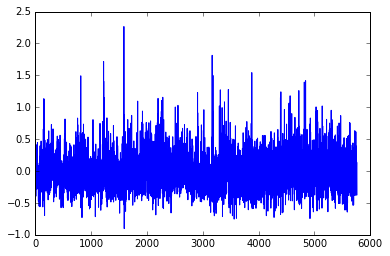

In [159]:
plt.plot(IT_Neural_Data[:, 0])

In [52]:
#ok so let's get all neurons from V4 to IT
res_V4_IT = [train_and_test_scikit_regressor(features=V4_Neural_Data, 
                                labels=IT_Neural_Data[:, i],
                                splits=reg_splits,
                                model_class=RidgeCV,
                                feature_norm=False) for i in range(IT_Neural_Data.shape[1])]


In [54]:
#and from IT to V4
#this is not "physical" (or maybe it is?  recurrence?)
res_IT_V4 = [train_and_test_scikit_regressor(features=IT_Neural_Data, 
                                labels=V4_Neural_Data[:, i],
                                splits=reg_splits,
                                model_class=RidgeCV,
                                feature_norm=False) for i in range(V4_Neural_Data.shape[1])]


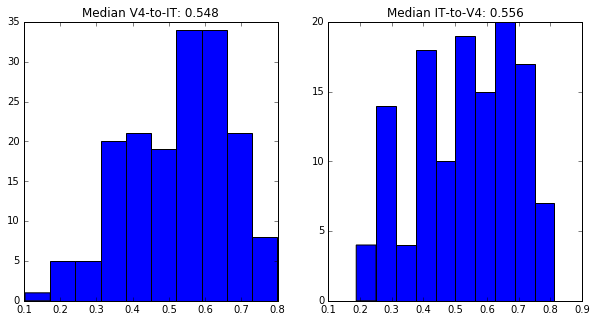

In [155]:
v4toit_ridgecv = [r['test']['mean_pearson'] for r in res_V4_IT]
ittov4_ridgecv = [r['test']['mean_pearson'] for r in res_IT_V4]
med_v4toit_ridgecv = np.median(v4toit_ridgecv) 
med_ittov4_ridgecv = np.median(ittov4_ridgecv) 

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(v4toit_ridgecv)
plt.title('Median V4-to-IT: %.3f' % med_v4toit_ridgecv)
plt.subplot(1, 2, 2)
plt.hist(ittov4_ridgecv )
plt.title('Median IT-to-V4: %.3f' % med_ittov4_ridgecv)



In [60]:
def idfunc(x):
    return x

def pearsonr(a, b):
    return stats.pearsonr(a, b)[0]

def spearmanr(a, b):
    return stats.spearmanr(a, b)[0]

def split_half_correlation(datas_by_trial,
                           num_splits,
                           aggfunc=idfunc,
                           statfunc=pearsonr):
    """
    Similar to split-half calculation from lecture 2, 
    but now allowing various aggregation and statistical comparison 
    functions
    """
        
    random_number_generator = np.random.RandomState(seed=0)

    corrvals = []
    for split_index in range(num_splits):
        stats1 = []
        stats2 = []
        for data in datas_by_trial:
            #get total number of trials
            num_trials = data.shape[0]

            #construct a new permutation of the trial indices
            perm = random_number_generator.permutation(num_trials)

            #take the first num_trials/2 and second num_trials/2 pieces of the data
            first_half_of_trial_indices = perm[:num_trials / 2]
            second_half_of_trial_indices = perm[num_trials / 2: num_trials]

            #mean over trial dimension
            s1 = aggfunc(data[first_half_of_trial_indices].mean(axis=0))
            s2 = aggfunc(data[second_half_of_trial_indices].mean(axis=0))
            stats1.extend(s1)
            stats2.extend(s2)
        
        #compute the correlation between the means
        corrval = statfunc(np.array(stats1), 
                           np.array(stats2))
        #add to the list
        corrvals.append(corrval)
        
    return spearman_brown(np.array(corrvals), 2)

In [61]:
#prep the by-trial data
IT_Data_by_trial = {}
V4_Data_by_trial = {}
for vl in ['V0', 'V3', 'V6']:
    level_number = vl[-1]
    arr = Ventral_Dataset['time_averaged']['variation_level_%s' % level_number][:, :, IT_NEURONS]
    IT_Data_by_trial[vl] = arr.swapaxes(0, 1)
    arr = Ventral_Dataset['time_averaged']['variation_level_%s' % level_number][:, :, V4_NEURONS]
    V4_Data_by_trial[vl] = arr.swapaxes(0, 1)

In [62]:
split_half_IT  = np.array([split_half_correlation([IT_Data_by_trial[vl][:, :, i].T for vl in ['V3', 'V6']],
                           num_splits=50,
                           aggfunc=idfunc,
                           statfunc=pearsonr).mean() for i in range(len(IT_NEURONS))])

split_half_V4  = np.array([split_half_correlation([V4_Data_by_trial[vl][:, :, i].T for vl in ['V3', 'V6']],
                           num_splits=50,
                           aggfunc=idfunc,
                           statfunc=pearsonr).mean() for i in range(len(V4_NEURONS))])

(array([  5.,   2.,   9.,   6.,  10.,   6.,  11.,  18.,  48.,  53.]),
 array([ 0.04976566,  0.14236026,  0.23495486,  0.32754946,  0.42014405,
         0.51273865,  0.60533325,  0.69792785,  0.79052245,  0.88311705,
         0.97571164]),
 <a list of 10 Patch objects>)

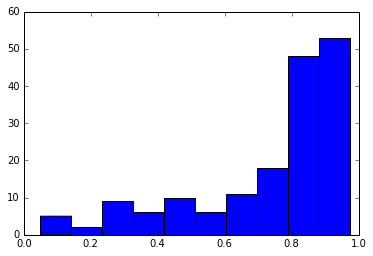

In [161]:
plt.hist(split_half_IT)

In [64]:
V4_IT_vec = np.array([r['test']['mean_pearson'] for r in res_V4_IT])
IT_V4_vec = np.array([r['test']['mean_pearson'] for r in res_IT_V4])

In [66]:
uncorrected = np.median(V4_IT_vec)
corrected = np.median(V4_IT_vec / split_half_IT)
print('V4-to-IT Uncorrected: %.3f; corrected: %.3f' % (uncorrected, corrected))

Uncorrected: 0.548; corrected: 0.713


In [68]:
uncorrected = np.median(IT_V4_vec)
corrected = np.median(IT_V4_vec / split_half_V4)
print('IT-to-V4 Uncorrected: %.3f; corrected: %.3f' % (uncorrected, corrected))

IT-to-V4 Uncorrected: 0.556; corrected: 0.700


### PLS Regression

In [78]:
from sklearn.cross_decomposition import PLSRegression

In [79]:
#With PLS Regression we can do all the predictions at once
#instead of having to create a separate regressor for each IT neuron
res_V4_IT_pls = train_and_test_scikit_regressor(features=V4_Neural_Data, 
                                labels=IT_Neural_Data,
                                splits=reg_splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25},
                                feature_norm=False)

res_V4_IT_pls['test']['mean_pearson']

0.53976493575417739

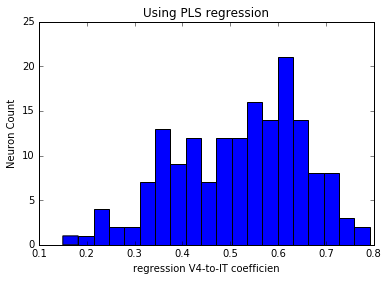

In [83]:
#so that's why this array of results is defined:
res_V4_IT_pls['test']['mean_pearson_array'].shape
plt.hist(res_V4_IT_pls['test']['mean_pearson_array'], bins=20)
plt.xlabel('regression V4-to-IT coefficien')
plt.ylabel('Neuron Count')
plt.title('Using PLS regression')

In [104]:
#let's actually analyze one trained model
one_split = cv.get_splits(metadata=meta_array, 
                           split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                           num_splits=1,  
                           num_per_class_test=5,  
                           num_per_class_train=75,
                           train_filter=lambda x: x['variation_level'] in ['V3', 'V6'],
                           test_filter=lambda x: x['variation_level'] in ['V3', 'V6']
                           )

res_V4_IT_pls_model = train_and_test_scikit_regressor(features=V4_Neural_Data, 
                                labels=IT_Neural_Data,
                                splits=one_split,
                                model_class=PLSRegression,
                                model_args={'n_components': 25, 'scale': False},
                                feature_norm=False,
                                return_models=True)

pls_model = res_V4_IT_pls_model['models'][0]

In [118]:
#Ok, so lets get the weights of the trained model
W = pls_model.coef_
W.shape
#see, this is the transform from V4 space (128 dim) to IT space (168) dimension

(128, 168)

In [ ]:
#now let's compute the projection
IT_Neural_Data_guess = np.dot(V4_Neural_Data, W)
#has the right shape 
IT_Neural_Data_guess.shape

In [119]:
IT_Neural_Data_guess[:, 0]

array([-0.04941157, -0.07605215,  0.06652948, ..., -0.08312364,
       -0.06397824,  0.10168661])

In [120]:
IT_Neural_Data_guess1 = pls_model.predict(V4_Neural_Data)
IT_Neural_Data_guess1[:, 0]
#so exactly, the prediction is done by the above mechanism

array([-0.04933132, -0.0759719 ,  0.06660973, ..., -0.08304339,
       -0.06389799,  0.10176686])

### Encoding Model Regression

In [121]:
#load pre-extracted features
dnnfile = h5py.File('/home/chengxuz/Class/psych253_2018/data/response_resnet34_all.hdf5', mode='r')

In [76]:
#this is the IT-like layer
dnnfile['encode_11']

<HDF5 dataset "encode_11": shape (5760, 14, 14, 256), type "<f4">

In [125]:
splits = cv.get_splits(metadata=meta_array, 
                           split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                           num_splits=1,  
                           num_per_class_test=5,  
                           num_per_class_train=75,
                           train_filter=lambda x: x['variation_level'] in ['V3', 'V6'],
                           test_filter=lambda x: x['variation_level'] in ['V3', 'V6']
                           )
    
dnnfeats = dnnfile['encode_11'][:].reshape((5760, 14 * 14 * 256))

In [127]:
res_dnn_IT_pls = train_and_test_scikit_regressor(features=dnnfeats, 
                                labels=IT_Neural_Data,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25, 'scale': False},
                                feature_norm=False) 

In [130]:
#reasonably good 
dnn_to_IT_vec = res_dnn_IT_pls['test']['mean_pearson_array']

uncorrected = np.median(dnn_to_IT_vec)
corrected = np.median(dnn_to_IT_vec/ split_half_IT)
print('DNN-to-IT Uncorrected: %.3f; corrected: %.3f' % (uncorrected, corrected))

DNN-to-IT Uncorrected: 0.532; corrected: 0.683
